In [ ]:
!pip3 install darts plotly

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

from darts import TimeSeries

import helper

In [ ]:
# Read a pandas DataFrame
# df = pd.read_parquet('Data/ldn_df_small.parquet')
# df

In [2]:
df = pd.read_csv('../../Data/london/household_MAC000002.csv')

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop(['stdorToU'], axis=1 , inplace=True)
df.drop(['timeOfDay'], axis=1 , inplace=True)
df.drop(["LCLid"], axis=1, inplace=True)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.loc[~df["DateTime"].duplicated(), :]
df["index"] = df.index
df.rename(columns={'KWH/hh (per half hour) ': 'KWH'} , inplace=True)
df

,DateTime,KWH,index
0,2012-10-12 00:30:00,0.000,0
1,2012-10-12 01:00:00,0.000,1
2,2012-10-12 01:30:00,0.000,2
3,2012-10-12 02:00:00,0.000,3
4,2012-10-12 02:30:00,0.000,4
...,...,...,...
24152,2014-02-27 22:00:00,0.416,24152
24153,2014-02-27 22:30:00,1.350,24153
24154,2014-02-27 23:00:00,1.247,24154
24155,2014-02-27 23:30:00,1.218,24155


In [4]:
helper.find_gaps(df)

5 gaps with median gap duration: 0 days 01:00:00
21      0 days 01:00:00
1046    0 days 01:00:00
1295    1 days 00:30:00
2860    0 days 01:00:00
22086   0 days 01:00:00
Name: DateTime, dtype: timedelta64[ns]


In [5]:
series = TimeSeries.from_dataframe(df, value_cols=['KWH'], time_col="DateTime")

In [6]:
#train, val = series.split_after(0.95)
train, val = series[:-48], series[-48:]


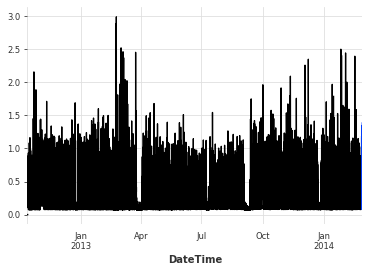

In [7]:
train.plot(label="training")
val.plot(label="validation")

In [ ]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

In [ ]:
model_nbeats.fit(series_1, val_series=series_2, verbose=True)

In [ ]:
pred_series = model_nbeats.historical_forecasts(
    series,
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)

display_forecast(pred_series, series,)

In [11]:
from darts.models import ExponentialSmoothing, Prophet, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(Prophet())
eval_model(NBEATSModel(input_chunk_length=30,output_chunk_length=7))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
[2022-03-30 16:07:14,633] INFO | darts.models.torch_forecasting_model | Train dataset contains 24108 samples.
[2022-03-30 16:07:14,633] INFO | darts.models.torch_forecasting_model | Train dataset contains 24108 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 24108 samples.


model Prophet obtains MAPE: 78.93%
